In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble.forest import RandomForestRegressor

In [30]:
def rmse(logY_pred,logY_act):
    rms=sqrt(mean_squared_error(logY_pred, logY_act))
    return rms

In [31]:
X_train = pd.read_csv('Data/train_data_hhp.csv')
X_test = pd.read_csv('Data/test_data_hhp.csv')

X_train, X_validation = train_test_split(X_train,test_size=0.3,random_state=0)

year_2_data = pd.read_csv('Data/train_data_hhp.csv')
year_2_data.drop(['DaysInHospital', 'Year', 'ClaimsTruncated', 'MemberID'], axis=1, inplace=True)

Y_train=X_train['DaysInHospital']
Y_test=X_test['DaysInHospital']
Y_validation=X_validation['DaysInHospital']

X_train.drop(['DaysInHospital','Year','ClaimsTruncated','MemberID'],axis=1, inplace=True)
X_test.drop(['DaysInHospital','Year','ClaimsTruncated','MemberID'],axis=1, inplace=True)
X_validation.drop(['DaysInHospital','Year','ClaimsTruncated','MemberID'],axis=1, inplace=True)

### Convert output by logscale


In [32]:
logYtrain=np.log(Y_train+1)
logYtest=np.log(Y_test+1)
logYvalidation=np.log(Y_validation+1)

## Training

### Predict 

In [33]:
rf_regr = RandomForestRegressor()

In [34]:
rf_regr.fit(X_train, logYtrain)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Evaluate

In [35]:
logY_pred_test = rf_regr .predict(X_test)
logY_pred_train = rf_regr .predict(X_train)
logY_pred_validation = rf_regr .predict(X_validation)

#truncated output
logY_pred_test[logY_pred_test < 0]=0
logY_pred_train[logY_pred_train < 0]=0
logY_pred_validation[logY_pred_validation < 0]=0

print('error on training set: ', rmse(logYtrain, logY_pred_train),
     'error on validation set: ', rmse(logYvalidation, logY_pred_validation),
  #   )#,
      'error on testing set: ', rmse(logYtest, logY_pred_test)
    )

error on training set:  0.20633913806981574 error on validation set:  0.49243086979575307 error on testing set:  0.4885525742376707


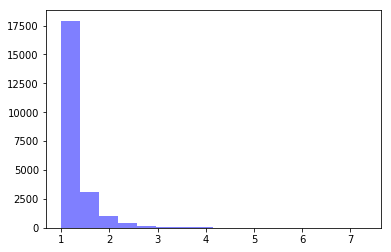

In [36]:
num_bins=16
n, bins, patches = plt.hist(np.exp(logY_pred_validation), num_bins, facecolor='blue', alpha=0.5)
plt.show()

### Feature selection

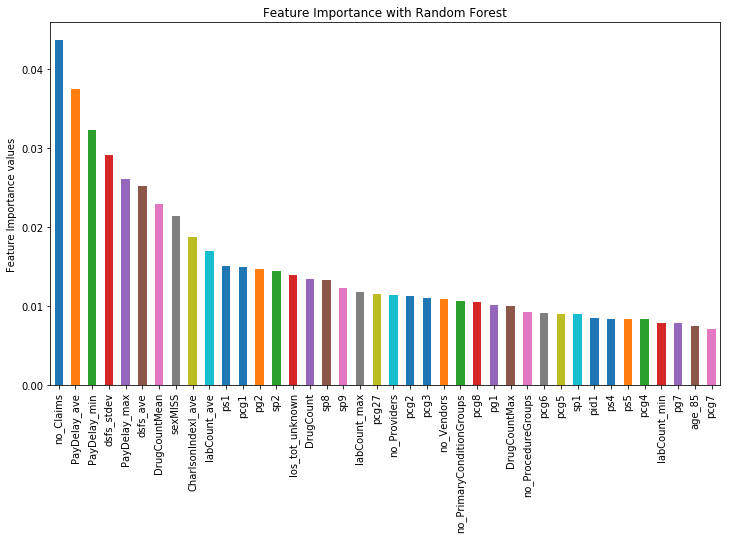

In [37]:
# Plot the top 40 important features
imp_feat_rf = pd.Series(rf_regr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp_feat_rf[:40].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
plt.savefig('FeatImportance.png')
plt.show()

#### Remove featurs with 0 importance value

In [38]:
#remove all features with 0 important value
list1=list()
for indx, val in imp_feat_rf.iteritems():
  #print(indx,val)
  if val==0:
    list1.append(indx)
#pd.DataFrame(list1).to_csv("Data/RmvSet1_XGBregr.csv", encoding='utf-8')

In [39]:
X_train.drop(list1,axis=1, inplace=True)
X_validation.drop(list1,axis=1, inplace=True)
X_test.drop(list1,axis=1, inplace=True)
year_2_data.drop(list1,axis=1, inplace=True)

In [40]:
rf_regr.fit(X_train,logYtrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [41]:
logY_pred_test = rf_regr .predict(X_test)
logY_pred_train = rf_regr .predict(X_train)
logY_pred_validation = rf_regr .predict(X_validation)

#truncated output
logY_pred_test[logY_pred_test < 0]=0
logY_pred_train[logY_pred_train < 0]=0
logY_pred_validation[logY_pred_validation < 0]=0


print('RSME on traing set',rmse(logYtrain, logY_pred_train),
        'RSME on validation set',rmse(logYvalidation, logY_pred_validation),
        'RSME on testing set',rmse(logYtest, logY_pred_test),
     )

RSME on traing set 0.2049871839547245 RSME on validation set 0.4922653057081607 RSME on testing set 0.48718000204953166


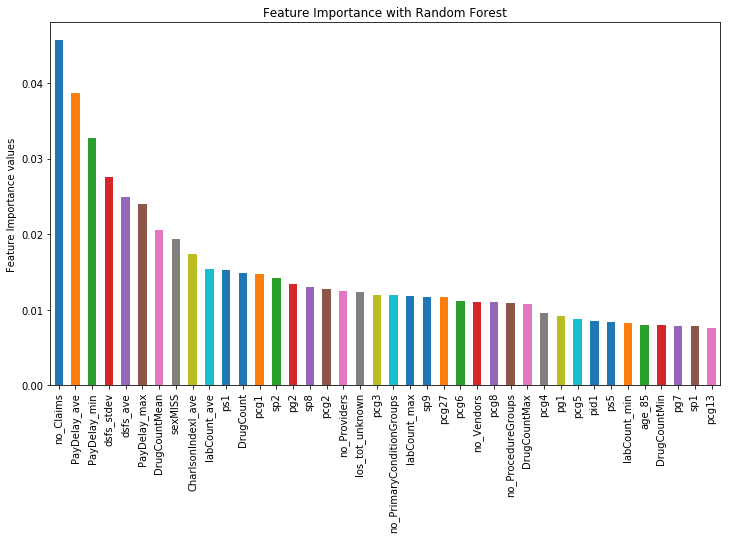

In [42]:
# Plot the top 40 important features
imp_feat_rf = pd.Series(rf_regr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp_feat_rf[:40].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
plt.savefig('FeatImportance.png')
plt.show()

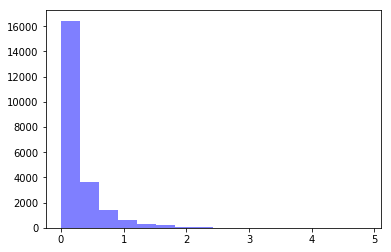

In [43]:
num_bins=16
n, bins, patches = plt.hist(np.exp(logY_pred_validation)-1, num_bins, facecolor='blue', alpha=0.5)
plt.show()

#### Remove features with high correlation with no_Claims

In [44]:
list0=['no_Providers', 'no_Vendors', 'no_PCPs', 'no_PlaceSvcs','no_Claims',
       'no_Specialities', 'no_PrimaryConditionGroups', 'no_ProcedureGroups']
del list0[4]
list0

['no_Providers',
 'no_Vendors',
 'no_PCPs',
 'no_PlaceSvcs',
 'no_Specialities',
 'no_PrimaryConditionGroups',
 'no_ProcedureGroups']

In [45]:
X_train.drop(list0,axis=1, inplace=True)
X_validation.drop(list0,axis=1, inplace=True)
X_test.drop(list0,axis=1, inplace=True)
year_2_data.drop(list0,axis=1, inplace=True)

In [46]:
rf_regr.fit(X_train,logYtrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [47]:
logY_pred_test = rf_regr .predict(X_test)
logY_pred_train = rf_regr .predict(X_train)
logY_pred_validation = rf_regr .predict(X_validation)

#truncated output
logY_pred_test[logY_pred_test < 0]=0
logY_pred_train[logY_pred_train < 0]=0
logY_pred_validation[logY_pred_validation < 0]=0

print('RSME on traing set',rmse(logYtrain, logY_pred_train),
        'RSME on validation set',rmse(logYvalidation, logY_pred_validation),
        'RSME on testing set',rmse(logYtest, logY_pred_test),
     )

RSME on traing set 0.20539119916099474 RSME on validation set 0.4890281977986687 RSME on testing set 0.4875247703639937


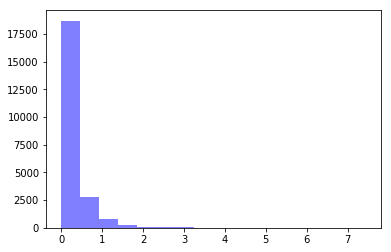

In [48]:
num_bins=16
n, bins, patches = plt.hist(np.exp(logY_pred_validation)-1, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [49]:
logY2_pred=rf_regr.predict(year_2_data)
logY2_pred[logY2_pred < 0]=0

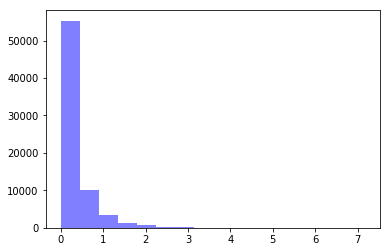

In [50]:
num_bins=16
n, bins, patches = plt.hist(np.exp(logY_pred_test)-1, num_bins, facecolor='blue', alpha=0.5)
plt.show()

## Export prediction

In [51]:
logY2_pred=rf_regr.predict(year_2_data)
logY2_pred[logY2_pred < 0]=0

Y2_pred=np.exp(logY2_pred)-1
Y3_pred=np.exp(logY_pred_test)-1

Y2_pred= pd.DataFrame(Y2_pred, columns=['Y_pred_RFregr_notScaled'])
Y3_pred= pd.DataFrame(Y3_pred, columns=['Y_pred_RFregr_notScaled'])
#Y_pred_validation= pd.DataFrame(Y_pred_validation, columns=['Y_pred_LGBM'])

In [ ]:
Y3_pred.head()

In [28]:
pd.DataFrame(Y2_pred).to_csv("Data/Y2_pred_RFregr_notScaled.csv", encoding='utf-8')
#pd.DataFrame(Y_pred_validation).to_csv("Data/Y_pred_validation_LGBM.csv", encoding='utf-8')
pd.DataFrame(Y3_pred).to_csv("Data/Y3_pred_RFregr_notScaled.csv", encoding='utf-8')

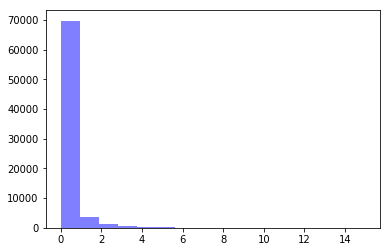

In [27]:
n, bins, patches = plt.hist(np.exp(logY2_pred)-1, num_bins, facecolor='blue', alpha=0.5)